In [143]:
import gzip
def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

In [144]:
import pandas as pd
df = pd.read_csv(
    "/Users/andrewchen/CSE158/Assignment_2/redditSubmissions.csv.gz",
    compression="gzip",
    on_bad_lines="skip",
    engine="python"
)

In [145]:
df.head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
0,0,1.333172e+09,2012-03-31T12:40:39.590113-07:00,And here's a downvote.,63470.0,rmqjs,32657.0,funny,30813.0,1.333198e+09,1844.0,622.0,Animates_Everything
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,Expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,Gangsta_Raper
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,Downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,Gangsta_Raper
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,Every time I downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,Gangsta_Raper
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,Downvote &quot;Dies Irae&quot;,65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,Gangsta_Raper


In [146]:
subreddit_counts = df.groupby('subreddit').count().sort_values(by='#image_id', ascending= False)[['#image_id']] 
subreddit_counts.iloc[:5]

,#image_id
subreddit,
funny,55277
pics,24712
gifs,12538
WTF,12193
aww,5920


<Figure size 1000x400 with 0 Axes>

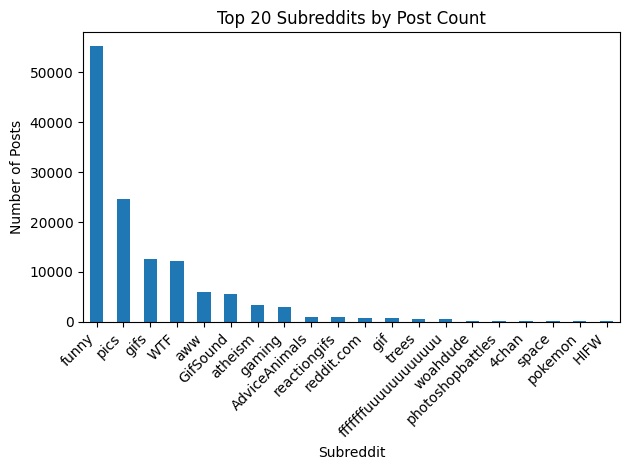

In [147]:
import matplotlib.pyplot as plt

# 1. Plot top 20 subreddits by count
top_n = 20
plt.figure(figsize=(10, 4))
subreddit_counts.iloc[:top_n].plot(
    kind='bar',
    legend=False
)
plt.title(f'Top {top_n} Subreddits by Post Count')
plt.ylabel('Number of Posts')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


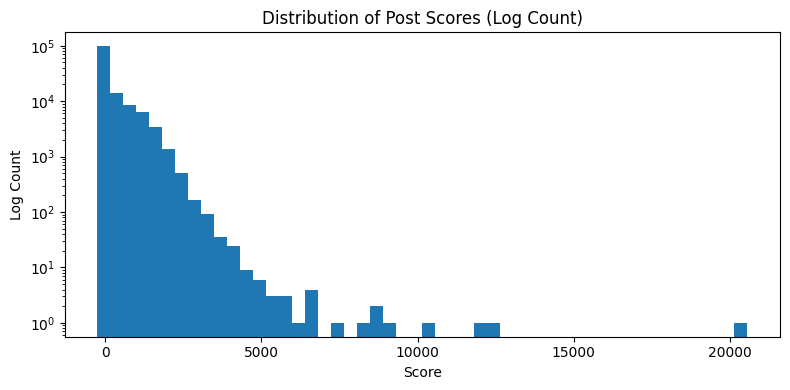

In [148]:
plt.figure(figsize=(8, 4))
plt.hist(df['score'], bins=50)
plt.yscale('log')
plt.title('Distribution of Post Scores (Log Count)')
plt.xlabel('Score')
plt.ylabel('Log Count')
plt.tight_layout()
plt.show()


In [149]:
# only 5 rows of net downvotes
df[df['score'] < 0].head()

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,username
5,0,1.333761e+09,2012-04-07T08:11:00-07:00,"Demolished, every time you downvote someone",40.0,rxwjg,17.0,gifs,23.0,1.333786e+09,-6.0,3.0,Hellothereawesome
7,0,1.339160e+09,2012-06-08T19:54:35.421944-07:00,getting that first downvote on a new post,13.0,usmxn,5.0,funny,8.0,1.339185e+09,-3.0,0.0,NaN
8,0,1.339408e+09,2012-06-11T16:44:39.947798-07:00,How reddit seems to reacts whenever I share a ...,14.0,uwzrd,6.0,funny,8.0,1.339433e+09,-2.0,0.0,NaN
9,0,1.339425e+09,2012-06-11T21:34:51.692933-07:00,Every LastAirBender post with a NSFW tag,20.0,uxf5q,9.0,pics,11.0,1.339450e+09,-2.0,0.0,HadManySons
10,0,1.340008e+09,2012-06-18T15:28:35.800140-07:00,How I felt when i forgot to put &quot;spoiler&...,21.0,v8vl7,10.0,gifs,11.0,1.340033e+09,-1.0,0.0,TraumaticASH


In [150]:
import numpy as np
import pandas as pd

# ---- 1. BASIC VALIDATION CHECKS ----

# score = upvotes - downvotes
score_diff = (df['number_of_upvotes'] - df['number_of_downvotes'] - df['score']).abs().sum()
print("Score consistency check (should be 0):", score_diff)

# total_votes = upvotes + downvotes
vote_diff = (df['number_of_upvotes'] + df['number_of_downvotes'] - df['total_votes']).abs().sum()
print("Total votes consistency check (should be 0):", vote_diff)

# no negative votes
neg_votes = ((df['number_of_upvotes'] < 0) | (df['number_of_downvotes'] < 0)).sum()
print("Number of rows with negative votes (should be 0):", neg_votes)

# duplicated posts via reddit_id
df = df.drop_duplicates(subset=['reddit_id'])
dup_reddit_ids = df['reddit_id'].duplicated().sum()
print("Number of duplicated reddit_id values:", dup_reddit_ids)

# missing values
print("\nMissing values per column:", df.isnull().sum().sum())

# ---- 2. TYPE CASTING ----

df['unixtime'] = pd.to_numeric(df['unixtime'], errors='coerce')
df['total_votes'] = df['total_votes'].astype(float)
df['number_of_upvotes'] = df['number_of_upvotes'].astype(float)
df['number_of_downvotes'] = df['number_of_downvotes'].astype(float)
df['score'] = df['score'].astype(float)

# (optional) drop the single row with any missing values
df = df.dropna().reset_index(drop=True)

# DROP ALL NEGATIVE SCORES
df = df[df["score"] >= 0]

# ---- 3. FEATURE ENGINEERING ----

df['datetime'] = pd.to_datetime(df['unixtime'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['year'] = df['datetime'].dt.year

df['title'] = df['title'].astype(str).str.strip()
df['title_length'] = df['title'].str.len()
df['word_count'] = df['title'].str.split().apply(len)

print("\nFinal dtypes:")
print(df.dtypes)


Score consistency check (should be 0): 0.0
Total votes consistency check (should be 0): 0.0
Number of rows with negative votes (should be 0): 0
Number of duplicated reddit_id values: 0

Missing values per column: 20258

Final dtypes:
#image_id                       int64
unixtime                      float64
rawtime                        object
title                          object
total_votes                   float64
reddit_id                      object
number_of_upvotes             float64
subreddit                      object
number_of_downvotes           float64
localtime                     float64
score                         float64
number_of_comments            float64
username                       object
datetime               datetime64[ns]
hour                            int32
dayofweek                       int32
year                            int32
title_length                    int64
word_count                      int64
dtype: object


In [151]:
import html
import re

def clean_title(text):
    # 1. Ensure string
    s = str(text)

    # 2. Unescape HTML entities: &quot; &amp; &lt; &gt; etc.
    s = html.unescape(s)

    # 3. Strip leading/trailing whitespace
    s = s.strip()

    # 4. Collapse multiple spaces/newlines into a single space
    s = re.sub(r'\s+', ' ', s)

    # 5. (Optional) lowercase for modeling
    s = s.lower()

    return s

df['title_clean'] = df['title'].apply(clean_title)
df['title'] = df['title_clean']
df.drop(columns=['title_clean'], inplace=True)

In [152]:
cols_to_use = [
    'unixtime', 'title', 'subreddit', 'score',
    'number_of_upvotes', 'number_of_downvotes', 'total_votes',
    'datetime', 'hour', 'dayofweek', 'year',
    'title_length', 'word_count'
]

df = df[cols_to_use]
df


,unixtime,title,subreddit,score,number_of_upvotes,number_of_downvotes,total_votes,datetime,hour,dayofweek,year,title_length,word_count
0,1.333172e+09,and here's a downvote.,funny,1844.0,32657.0,30813.0,63470.0,2012-03-31 05:40:39,5,5,2012,22,4
1,1.333178e+09,expectation,GifSound,23.0,29.0,6.0,35.0,2012-03-31 07:16:01,7,5,2012,11,1
2,1.333200e+09,downvote,GifSound,23.0,32.0,9.0,41.0,2012-03-31 13:18:33,13,5,2012,8,1
3,1.333252e+09,every time i downvote something,GifSound,2.0,6.0,4.0,10.0,2012-04-01 03:52:10,3,6,2012,31,5
4,1.333273e+09,"downvote ""dies irae""",GifSound,49.0,57.0,8.0,65.0,2012-04-01 09:35:54,9,6,2012,30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111958,1.344760e+09,om nom nom,funny,16.0,25.0,9.0,34.0,2012-08-12 08:24:06,8,6,2012,10,3
111959,1.345270e+09,don't feed the animals...,funny,9.0,14.0,5.0,19.0,2012-08-18 06:09:38,6,5,2012,25,4
111960,1.345954e+09,wtf worthy.,WTF,3.0,26.0,23.0,49.0,2012-08-26 04:06:02,4,6,2012,11,2
111961,1.346626e+09,"just a camel eating a kids head, welcome to th...",WTF,7.0,65.0,58.0,123.0,2012-09-02 22:45:06,22,6,2012,56,11


In [153]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def add_title_sentiment(df):
    titles = df['title'].astype(str)

    scores = titles.apply(sia.polarity_scores)   # each is a dict
    scores_df = scores.apply(pd.Series)         # -> columns: neg, neu, pos, compound

    df['title_sent_neg'] = scores_df['neg']
    df['title_sent_neu'] = scores_df['neu']
    df['title_sent_pos'] = scores_df['pos']
    df['title_sent_compound'] = scores_df['compound']

    return df

df = add_title_sentiment(df)


In [154]:
# MODELING

# make sure to drop total_votes, upvotes, downvotes, number_of_commetns
# lets drop all subreddits with < 20 posts

In [155]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 1. Split helper (so you always use the same split)
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=158):
    """
    Splits X, y into train/val/test.
    val_size is the fraction of the *original* data.
    """
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    val_frac_of_temp = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_frac_of_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


# 2. Metric display helper
def eval_regression(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)

    print(f"{name}")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return {"model": name, "mae": mae, "rmse": rmse}


# 3. Convenience wrapper: fit model + evaluate on a given split
def fit_and_evaluate(model, X_train, y_train, X_val, y_val, name=None):
    """
    Fits the model on (X_train, y_train) and evaluates on (X_val, y_val).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    model_name = name or model.__class__.__name__
    scores = eval_regression(y_val, y_pred, name=model_name)
    return model, scores


In [156]:
feature_cols = [
    'title', 'subreddit',
    'datetime', 'hour', 'dayofweek', 'year',
    'title_length', 'word_count'
]

X = df[feature_cols]
y = df['score']   # or df['score_log'] if you later transform it

In [157]:
# from before
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)


In [158]:
df.head()

,unixtime,title,subreddit,score,number_of_upvotes,number_of_downvotes,total_votes,datetime,hour,dayofweek,year,title_length,word_count,title_sent_neg,title_sent_neu,title_sent_pos,title_sent_compound
0,1.333172e+09,and here's a downvote.,funny,1844.0,32657.0,30813.0,63470.0,2012-03-31 05:40:39,5,5,2012,22,4,0.0,1.0,0.0,0.0
1,1.333178e+09,expectation,GifSound,23.0,29.0,6.0,35.0,2012-03-31 07:16:01,7,5,2012,11,1,0.0,1.0,0.0,0.0
2,1.333200e+09,downvote,GifSound,23.0,32.0,9.0,41.0,2012-03-31 13:18:33,13,5,2012,8,1,0.0,1.0,0.0,0.0
3,1.333252e+09,every time i downvote something,GifSound,2.0,6.0,4.0,10.0,2012-04-01 03:52:10,3,6,2012,31,5,0.0,1.0,0.0,0.0
4,1.333273e+09,"downvote ""dies irae""",GifSound,49.0,57.0,8.0,65.0,2012-04-01 09:35:54,9,6,2012,30,3,0.0,1.0,0.0,0.0


In [159]:
import numpy as np
import pandas as pd

# ---- Baseline 1: Global mean predictor ----
global_mean = y_train.mean()
print(f"Global mean score (train): {global_mean:.4f}")

# constant prediction = global mean
y_val_pred_global = np.full_like(y_val, fill_value=global_mean, dtype=float)
eval_regression(y_val, y_val_pred_global, name="Baseline: Global Mean")


# ---- Baseline 2: Subreddit mean (with fallback to global mean) ----

# compute mean score per subreddit on TRAIN ONLY
train_df_for_means = pd.DataFrame({
    'subreddit': X_train['subreddit'].values,
    'score': y_train.values
})
subreddit_means = train_df_for_means.groupby('subreddit')['score'].mean()

def predict_subreddit_mean(X, subreddit_means, global_mean):
    """
    For each row in X, predict the mean score of its subreddit,
    falling back to the global mean if the subreddit was unseen in training.
    """
    return X['subreddit'].map(subreddit_means).fillna(global_mean).values

# predictions on validation set
y_val_pred_sub = predict_subreddit_mean(X_val, subreddit_means, global_mean)
eval_regression(y_val, y_val_pred_sub, name="Baseline: Subreddit Mean + Global Fallback")


Global mean score (train): 299.2110
Baseline: Global Mean
  MAE : 380.2324
  RMSE: 525.9766
Baseline: Subreddit Mean + Global Fallback
  MAE : 364.0221
  RMSE: 512.7617


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'model': 'Baseline: Subreddit Mean + Global Fallback',
 'mae': 364.02212823134687,
 'rmse': 512.7617237464975}

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# ---------------------------
# 1. Select the features Random Forest can use
# ---------------------------
rf_feature_cols = [
    'subreddit',
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

X_rf = df[rf_feature_cols]
y = df['score']   # or df['score_log']


# ---------------------------
# 2. Train/val/test split
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X_rf, y, test_size=0.20, random_state=158
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=158
)


# ---------------------------
# 3. Preprocess categorical + numeric
# ---------------------------
categorical_cols = ['subreddit']
numeric_cols = [
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)


# ---------------------------
# 4. Define Random Forest model
# ---------------------------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,      # let the model grow
    min_samples_split=2,
    random_state=158,
    n_jobs=-1
)


# ---------------------------
# 5. Create the modeling pipeline
# ---------------------------
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_model)
])


# ---------------------------
# 6. Fit & Evaluate on validation set
# ---------------------------
rf_pipeline.fit(X_train, y_train)
y_val_pred = rf_pipeline.predict(X_val)

eval_regression(y_val, y_val_pred, name="Random Forest (Metadata + Sentiment)")


Random Forest (Metadata + Sentiment)
  MAE : 385.6568
  RMSE: 555.0914


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'model': 'Random Forest (Metadata + Sentiment)',
 'mae': 385.65678488978045,
 'rmse': 555.0913941048566}

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# ---------------------------
# 1. Define X and y
# ---------------------------

ridge_feature_cols = [
    'title', 'subreddit',
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

X = df[ridge_feature_cols]
y = df['score']          # or df['score_log'] if you transform


# ---------------------------
# 2. Train / val / test split (80/10/10)
# ---------------------------

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=158
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=158
)


# ---------------------------
# 3. ColumnTransformer for preprocessing
# ---------------------------

text_col = 'title'
cat_cols = ['subreddit']
num_cols = [
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

preprocessor = ColumnTransformer(
    transformers=[
        # TF-IDF on title text
        ('text', TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),   # unigrams + bigrams
            min_df=5
        ), text_col),

        # One-hot encode subreddit
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),

        # Scale numeric + sentiment features
        ('num', StandardScaler(), num_cols),
    ]
)


# ---------------------------
# 4. Ridge regression model
# ---------------------------

ridge = Ridge(alpha=1.0, random_state=158)


# ---------------------------
# 5. Full pipeline: preprocess -> model
# ---------------------------

ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', ridge),
])


# ---------------------------
# 6. Fit & evaluate on validation set
# ---------------------------

ridge_pipeline.fit(X_train, y_train)
y_val_pred = ridge_pipeline.predict(X_val)

eval_regression(y_val, y_val_pred, name="Ridge (TF-IDF + Metadata + Sentiment)")


Ridge (TF-IDF + Metadata + Sentiment)
  MAE : 371.4220
  RMSE: 536.7824


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'model': 'Ridge (TF-IDF + Metadata + Sentiment)',
 'mae': 371.4220151839853,
 'rmse': 536.7823819587971}

In [162]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# ------------- 1. Define X and log-transformed y  -------------

ridge_feature_cols = [
    'title', 'subreddit',
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

X = df[ridge_feature_cols]

# raw and log targets
y_raw = df['score']
y_log = np.log1p(df['score'])   # log(1 + score)


# ------------- 2. Train / val / test split (keep raw + log aligned) -------------

X_train, X_temp, y_train_log, y_temp_log, y_train_raw, y_temp_raw = train_test_split(
    X, y_log, y_raw, test_size=0.20, random_state=158
)

X_val, X_test, y_val_log, y_test_log, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp_log, y_temp_raw, test_size=0.50, random_state=158
)


# ------------- 3. Preprocessing (TF-IDF + OHE + scaling) -------------

text_col = 'title'
cat_cols = ['subreddit']
num_cols = [
    'hour', 'dayofweek', 'year',
    'title_length', 'word_count',
    'title_sent_neg', 'title_sent_neu', 'title_sent_pos', 'title_sent_compound'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            min_df=5
        ), text_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols),
    ]
)


# ------------- 4. Base Ridge pipeline (we'll tune alpha) -------------

base_ridge = Ridge(random_state=158)

ridge_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', base_ridge),
])


# ------------- 5. Hyperparameter tuning for alpha (on log target) -------------

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 3, 10, 30, 100]
}

grid = GridSearchCV(
    ridge_pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # avoid deprecated 'squared' flag
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train_log)

print("Best params:", grid.best_params_)
print("Best CV RMSE (log space):", -grid.best_score_)


# ------------- 6. Evaluate best model on validation set (in RAW score space) -------------

best_ridge = grid.best_estimator_

# predict log-scores, then invert log1p
y_val_pred_log = best_ridge.predict(X_val)
y_val_pred_raw = np.expm1(y_val_pred_log)

eval_regression(y_val_raw, y_val_pred_raw, name="Ridge (TF-IDF, tuned alpha, log target)")


Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best params: {'model__alpha': 30}
Best CV RMSE (log space): 1.9998694947975053
Ridge (TF-IDF, tuned alpha, log target)
  MAE : 288.6693
  RMSE: 581.0511


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'model': 'Ridge (TF-IDF, tuned alpha, log target)',
 'mae': 288.6692827330579,
 'rmse': 581.0511209750684}